In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os, sys
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from utils import random_cv_split, int_col_to_string, string_col_to_int, encode_column


# Load Data

Read the data into a panda dataframe

Build training data using the not null data and a prediction set using the null data.

Then split up the training data into a training set and a cross validation set by randomly splitting items up by their program priority code.

In [80]:
df = pd.read_excel('data/LA_Budget_Data.xlsx')

In [81]:
for column in df.columns:
    
    nulls = df[column].isnull().any()
    print(column, "has nulls: ", nulls)


Dept_Code has nulls:  True
Department_Name has nulls:  False
SubDept_Code has nulls:  False
SubDepartment_Name has nulls:  False
Prog_Code has nulls:  True
Program_Name has nulls:  True
Program_Priority has nulls:  True
Source_Fund_Code has nulls:  True
Source_Fund_Name has nulls:  True
Account_Code has nulls:  True
Account_Name has nulls:  True
Appropriation has nulls:  False
Fiscal_Year has nulls:  False
Expense_Type has nulls:  True


In [82]:
decoders = {}


decoders["Department_Name"] = encode_column(df, "Department_Name")
decoders["SubDepartment_Name"] = encode_column(df, "SubDepartment_Name")

full_data = df[df["Expense_Type"].notnull()]
full_data = full_data.dropna(how='any')

encode_column(full_data, "Expense_Type")
encode_column(full_data, "Program_Priority")
encode_column(full_data, "Program_Name")
encode_column(full_data, "Account_Name")


empty_data = df[False == df["Expense_Type"].notnull()]


single_empty = empty_data[empty_data["Account_Name"].notnull()]
all_empty = empty_data[False == empty_data["Account_Name"].notnull()]

priorities = full_data["Program_Priority"].unique()
programs = full_data["Program_Name"].unique()
expenses = full_data["Expense_Type"].unique()
departments = full_data["Dept_Code"].unique()

guaranteed = ["Encoded_SubDepartment_Name", "Encoded_Department_Name", "Appropriation"]
not_guaranteed = ["Encoded_Program_Name", "Encoded_Program_Priority", "Encoded_Account_Name"]

all_keys = guaranteed + not_guaranteed

In [57]:
full_data.shape

(14243, 20)

# Test a hardcoded method to serve as baseline

To me, it looks like the only guaranteed info for the rows that don't have expense type is the department name
and appropriation, so that's what i'll build the baseline model using.
Algorithm: For each row in the dataset find all other rows with the same department name. Then,
out of these rows, find the row that has the appropriation value closest to the current row's. Lastly,
check if the expense types are equal and add to accuracy score if so.

Possible Extensions: Find 'n' closest rows and then take a polling on their expense types when making final prediction.



In [15]:
#keep a count to keep track of current row
count = 0
#used for accuracy metric
num_total =0
num_correct = 0.0
#sometimes an error occurs when taking the mean, so I just keep track to make sure its no big deal
num_minargerr = 0


for index, row in full_data.iterrows():
    #current_rows appropriation
    approp_amount = row["Appropriation"]
    indexes = list(np.where(full_data["Department_Name"] == row["Department_Name"])[0])
    
    #remove current row from the search
    indexes = list(filter(lambda a: a != count, indexes))
    
    #search through rows that have same department name
    searching = full_data.iloc[indexes]
    searching_list = searching["Appropriation"].tolist()
    
    #sometimes searching_list is null and triggers an error
    try:
        #get row with closest appropriation amount
        closest_index = min(range(len(searching_list)), key=lambda i: abs(searching_list[i]-approp_amount))
        closest_row = searching.iloc[closest_index]
        
        if(row["Expense_Type"] == closest_row["Expense_Type"]):
            num_correct += 1
    except:
        num_minargerr +=1
    
    num_total += 1
    count+=1
print("Number of errors:", num_minargerr)
print("Accuracy:", num_correct/num_total)

Number of errors: 3
Accuracy: 0.7497718177350278


# Look For Easy Correlations

Other than Dept_Code and Program name, there don't appear to be any great correlations with Expense type. I'm not too optimistic about this approach, but let's see how it goes.

In [16]:
full_data.corr()

,Appropriation,Fiscal_Year,Encoded_Department_Name,Encoded_SubDepartment_Name,Encoded_Expense_Type,Encoded_Program_Priority,Encoded_Program_Name,Encoded_Account_Name
Appropriation,1.000000,0.017380,0.022168,0.041060,0.036633,0.008716,-0.004502,0.009344
Fiscal_Year,0.017380,1.000000,-0.138887,0.032914,-0.092946,-0.292256,0.038540,-0.023045
Encoded_Department_Name,0.022168,-0.138887,1.000000,0.530920,0.040165,-0.125534,0.138764,-0.032562
Encoded_SubDepartment_Name,0.041060,0.032914,0.530920,1.000000,0.075124,0.018711,0.071454,0.005377
Encoded_Expense_Type,0.036633,-0.092946,0.040165,0.075124,1.000000,0.054820,-0.025987,0.298865
Encoded_Program_Priority,0.008716,-0.292256,-0.125534,0.018711,0.054820,1.000000,0.011057,0.022938
Encoded_Program_Name,-0.004502,0.038540,0.138764,0.071454,-0.025987,0.011057,1.000000,-0.015946
Encoded_Account_Name,0.009344,-0.023045,-0.032562,0.005377,0.298865,0.022938,-0.015946,1.000000


# Try Random Forest

Try running data through a random forest classifier with various combinations to see how they work

In [17]:

#string_col_to_int("Dept_Code", departments, full_data)

def train_and_score_rfc(data, train_keys,  iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    rfc_low = RandomForestClassifier(n_estimators=10)

    
    for i in range(iterations):
        rfc_low.fit(train[train_keys], train["Expense_Type"])
        score = rfc_low.score(cv[train_keys], cv["Expense_Type"])
        print("Keys: ", train_keys)
        print(" Acc: ", score )

    
    return rfc_low

rfc_g = train_and_score_rfc(full_data, guaranteed)
rfc_ng = train_and_score_rfc(full_data, not_guaranteed)

rfc_sg = train_and_score_rfc(full_data, guaranteed+["Encoded_Account_Name"])

Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation']
 Acc:  0.736478711162
Keys:  ['Encoded_Program_Name', 'Encoded_Program_Priority', 'Encoded_Account_Name']
 Acc:  0.970684803002
Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation', 'Encoded_Account_Name']
 Acc:  0.98445229682


So interesting results here: It seems that the best individual indicator is simply Appropriation which makes sense. Then is program name and not far behind Dept code. Last is program priority which makes sense because that was a complex description. So this is kind of good news because for about 200 rows, the only info we have is the dept code and appropriation, so for those rows which we can't run embeddings on, we can still get descent results, given the ~75% accuracy of the only guaranteed keys

Now I'm going to try a few combinations just to get a better feel for data

In [18]:
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Priority", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", "Encoded_Department_Name"] )
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", 
                                      "Encoded_SubDepartment_Name", "Encoded_Department_Name", 
                                      "Encoded_Account_Name"] )
rfc_all = train_and_score_rfc(full_data, all_keys)

Keys:  ['Encoded_Program_Name', 'Appropriation']
 Acc:  0.748760330579
Keys:  ['Encoded_Program_Priority', 'Appropriation']
 Acc:  0.616149930588
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_Department_Name']
 Acc:  0.77743902439
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Encoded_Account_Name']
 Acc:  0.985807352257
Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation', 'Encoded_Program_Name', 'Encoded_Program_Priority', 'Encoded_Account_Name']
 Acc:  0.978439184439


So the best combination is essentially the guaranteed columns plus the embedded column. Which is something to keep in mind for later. I'm interested to see how the random forest results differ with a word2vec embedding of account namme, to see if it can potentially find general trend in the embedding.

# View the Decision Breakdown

I'm going to plot the decision breakdown of the guaranteed and not guaranteed rfc to see if they lend any insights

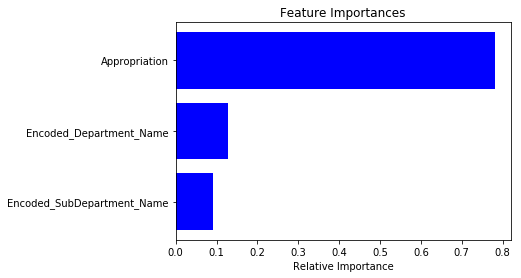

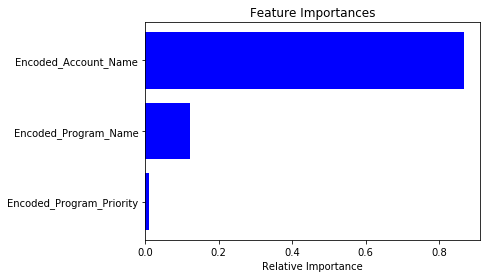

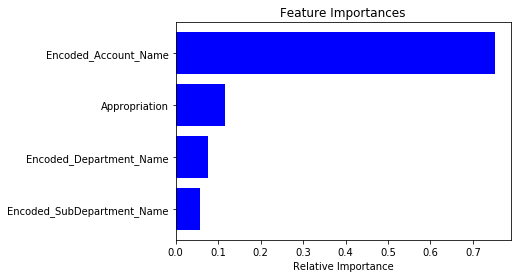

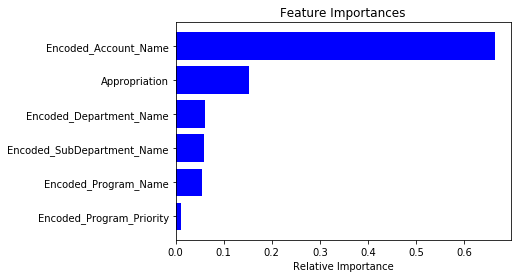

In [19]:
def plot_rfc_weights(forest, columns, fig_num=1):
    
    importances = forest.feature_importances_
    columns=np.array(columns)

    indices = np.argsort(importances)

    plt.figure(fig_num)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), columns[indices])
    plt.xlabel('Relative Importance')

    return

plot_rfc_weights(rfc_g, guaranteed, 1)
plot_rfc_weights(rfc_ng, not_guaranteed, 2)
plot_rfc_weights(rfc_sg, guaranteed + ["Encoded_Account_Name"], 3)
plot_rfc_weights(rfc_all, all_keys, 4)

# TakeAway

So, unsurprisingly, the Appropriation ammmount is by far the most considered part of the data, followed by the program name. I'm gonna try to do some more work with the program name to extract more information from it later on

In [20]:
from sklearn import svm


def train_and_score_svc(data, iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    svc_g = svm.SVC()
    svc_ng = svm.SVC()
    
    for i in range(iterations):

        svc_g.fit(train[guaranteed], train["Expense_Type"])
        score = svc_g.score(cv[guaranteed], cv["Expense_Type"])
        print("SVC guaranteed data Score: ", score)


        svc_ng.fit(train[guaranteed+not_guaranteed], train["Expense_Type"])
        score = svc_ng.score(cv[guaranteed+not_guaranteed], cv["Expense_Type"])
        print("SVC not guaranteed data Score: ", score)
    
    
    return svc_g, svc_ng

svc_g, svc_ng = train_and_score_svc(full_data)


SVC guaranteed data Score:  0.663143382353
SVC not guaranteed data Score:  0.649356617647


Not as good results as Random Forest, but it seems to scale better. With a smaller dataset I might use svm, but becasue we have around 80% of the data already filled and 20% not filled, I'm leaning towards the random forest

Also, SVM performs worse given the program name and ID, because it probably just adds unneccessary complexity towards the fitting.

In [21]:
fa = full_data["Account_Name"].unique()
ea = single_empty["Account_Name"].unique()

ea = ea[1:]

only_ea = np.setdiff1d(ea,fa)

print("Number of empty data accounts", len(ea))
print("Number of empty data accounts not in full data", len(only_ea))

Number of empty data accounts 809
Number of empty data accounts not in full data 808


# More Data Preparations

Now, I want to prepare training data for a deep learning approach. My plan is to have 2 different models to train. 1 that only accepts the guaranteed information i.e. the department and the appropriation and tries to predict the expense type. Another that takes in the department, appropriation and the sentence vector describing the department. I have 2 functions below used to build up the corresponding datasets.

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    
def one_hot_Y(Y):
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(Y)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded, label_encoder
    
def build_train_set(df, columns):

    
    X_data = df[columns].values
    
    Y = df["Expense_Type"].values
    
    Y, decoder = one_hot_Y(Y)
    
    return  X_data, Y, decoder


X, Y, decoder = build_train_set(full_data, guaranteed)

# Takeaway

So unsurprisingly, the model can't even fit the training set much above 50%, much less a test set. I don't see much gain by hyper-parameter tinkering at this point. I think the route to take with the only guaranteed data filling in is just using the random forest. Now I'm gonna try out the non-guaranteed data sentance encoding to see if it helps much. I don't have great hopes, but it's worth a try :)

# As Expected, Neural Nets are not the way to go

There are so many different inputs and there is such little correlation between the various word2vec inputs to the result, DL is not the way to go.

I'm going to try some other methods to fit the data they won't have too much fruition

Building a cv splitting function for a cross validation set randomly

In [23]:
def np_cv_split(x, y):
    
    index = np.random.rand(x.shape[0]) > .5
    
    train_x = x[index]
    train_y = y[index]
    
    cv_x = x[False == index]
    cv_y = y[False == index]
    
    return train_x, train_y, cv_x, cv_y 

train_x, train_y, cv_x, cv_y = np_cv_split(X, Y)

# Try to fit data using SVM

I'm not expecting much better results than the Network, but por favor prove me wrong :)

In [24]:
svc = svm.SVC()

svc.fit(train_x, train_y.argmax(axis=1))

svc.score(cv_x, cv_y.argmax(axis=1))

0.6292559899117276

# Try RFC

I don't think RFC will perform much better than the baseline because of all the extra noise the word2vec data provides. Again- por favor prove me wrong :)

In [25]:
rfc_low = RandomForestClassifier(n_estimators=30)

rfc_low.fit(train_x, train_y)
score = rfc_low.score(cv_x, cv_y)
print(" Acc: ", score )

 Acc:  0.710942973238


As I suspected, none of these performed better than the baseline model with only the guaranteed data. I think the reason for this decrease in performance, despite the increase in information, is that the word2vec model, even if it provides some relevent information to the prediction, it provides so much information that these various models, especially ensemble models such as RFC and NNs will be able to find a number of "correlations" that are coincidental in our data, and have no actually effect on predicting expense type

# N-Grams

So, I realized, looking back through the data, I really just wanted to quantify certain keyword phrases. In order to reach this quantification, without bring on all the extra garbage of word2vec, I'm going to instead create a one-hot vectorization of N-grams, in order to detect the presence or abscence of certain key-words or phrases

Creating bi-gram data, and concatenating with the guaranteed data

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

account_names = full_data["Account_Name"].tolist()
make_ngram = CountVectorizer()

n_grams = make_ngram.fit_transform(account_names).toarray()

other_data = full_data[guaranteed].as_matrix()

X = np.concatenate([other_data, n_grams], axis=1)

Creating an index that separates a certain number of entire account names- thus, the account names in our test set will have never appeared in our training set. This will allow us to get an accurate determination as to how it will perform on the new data

In [27]:
unique = full_data["Account_Name"].unique()

index = np.random.rand(unique.shape[0]) > .3

training_accounts = set(unique[index])
test_accounts = set(unique[False == index])

def in_training(x):
    return x in training_accounts

index = full_data["Account_Name"].apply(in_training)


def account_cv_split(x, y, index):
    
    
    train_x = x[index]
    train_y = y[index]
    
    cv_x = x[False == index]
    cv_y = y[False == index]
    
    return train_x, train_y, cv_x, cv_y 


# two splits - 1 with just the ngram data, 1 with additional data added
X_ngram_train, Y_ngram_train, X_ngram_test, Y_ngram_test = account_cv_split(n_grams, full_data["Expense_Type"], index)
X_train, Y_train, X_test, Y_test = account_cv_split(X, full_data["Expense_Type"], index)


print("CV Split. Train:", X_train.shape[0], "Test: ", X_test.shape[0])

CV Split. Train: 11254 Test:  2989


# Visualize To Featurpe Weights

Get a list of the feature weights of the best scoring rfc for assessment

In [28]:
def plot_ngram_rfc(rfc, fignum, acc):

    cols = range(303)

    features_and_weights = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), cols), 
                 reverse=True)

    important_phrases = []
    weights = []

    
    for pair in features_and_weights[0:30]:
        one_hot = np.zeros([720])
        one_hot[pair[1]-3] = 1
        phrase = make_ngram.inverse_transform(one_hot)[0]
        phrase = " ".join(phrase.tolist())

        important_phrases.append(phrase)
        weights.append(pair[0])


    plt.figure(num=fignum, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Acc:'+ str(acc) )
    plt.barh(range(len(weights)), weights, color='b', align='center')
    plt.yticks(range(len(important_phrases)), important_phrases)
    plt.xlabel('Relative Importance')


# Random Forest Attempt

So random forest is gave good results, but also wildly fluctuated based on the random state: in order to combat this inconsistency, I set max features from sqrt to log2, and increased the estimators

Random State  34 Accuracy:  0.838407494145
Random State  67 Accuracy:  0.851455336233


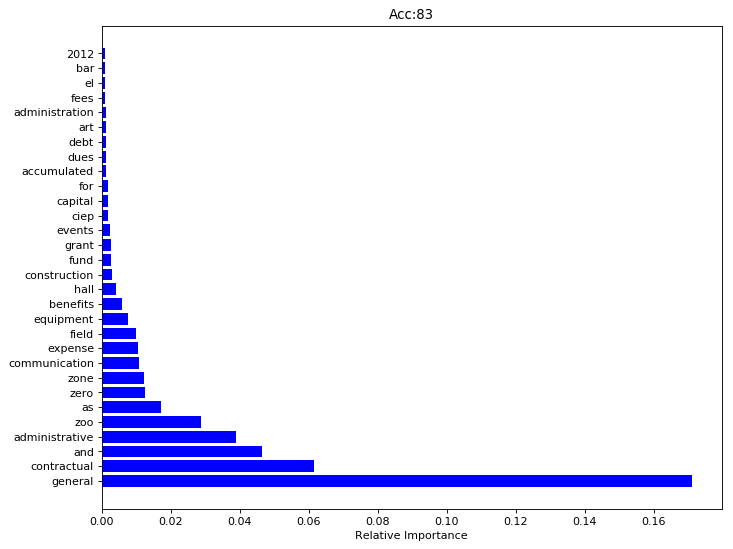

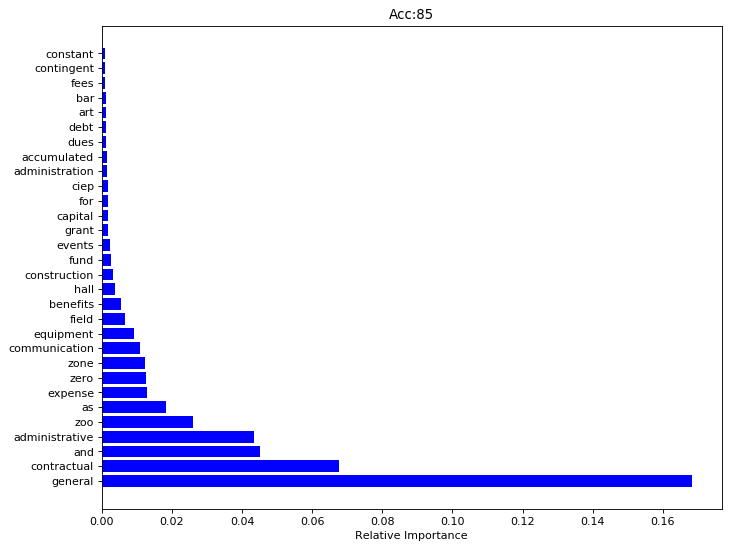

In [29]:
from random import random

max_accuracy = 0

for i in range(2):
    
    state = int(random()*100) 
    
    rfc = RandomForestClassifier(n_estimators=200, random_state=state, max_features='log2')
    
    rfc.fit(X_train, Y_train)
    
    acc = rfc.score(X_test, Y_test)
    
    plot_ngram_rfc(rfc, i, int(100*acc))
    
    if acc > max_accuracy:
        rfc_keep = rfc

    print("Random State ", state, "Accuracy: ", acc)

In [30]:
from sklearn.metrics import confusion_matrix

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)


label_encoder.fit(Y_test)

Y_test_encoded = label_encoder.transform(Y_test)
Y_pred_encoded = label_encoder.transform(rfc_keep.predict(X_test))

Y_test_encoded = Y_test_encoded.reshape(Y_test_encoded.shape[0], 1)
Y_pred_encoded = Y_pred_encoded.reshape(Y_test_encoded.shape[0], 1)

onehot_encoder.fit(Y_test_encoded)

cols = label_encoder.inverse_transform(np.array(range(9)))

Y_test_encoded = onehot_encoder.transform(Y_test_encoded).argmax(axis=1)
Y_pred_encoded = onehot_encoder.transform(Y_pred_encoded).argmax(axis=1)

conf_arr = confusion_matrix(Y_test_encoded, Y_pred_encoded)

print(cols)
print(conf_arr)

['Benefits' 'Debt Service' 'Equipment' 'Expenses' 'Other' 'Reserves'
 'Salaries' 'Special' 'Transportation']
[[   0    0    0    1    3    0    0    0    0]
 [   0   23    0    1    1    0    0    0    0]
 [   0    0    0   68   16    0    0    0    0]
 [   0    0    0 1979  141    0    0    1    0]
 [   0    0    1   53  252    0    0    0    0]
 [   0    0    0    0    4    0    1    0    0]
 [   0    0    0   50    4    0  290   60    0]
 [   0    1    0   24    4    0    0    1    0]
 [   0    0    0    3    5    0    2    0    0]]


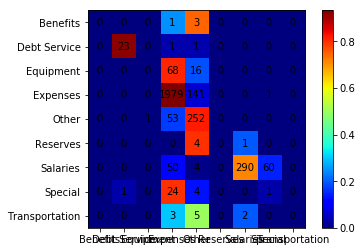

In [31]:
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plt.xticks(range(width), cols[:width])
plt.yticks(range(height), cols[:height])
plt.savefig('confusion_matrix.png', format='png')

In [32]:
(Y_test_encoded == Y_pred_encoded).sum()/(Y_test_encoded.shape[0])

0.85145533623285374

So I'm a little surprised at the importances of some words: not too much at others

## Create a training set of only the Important columns

There are a number of columns that are barely weighted by the RFC- I'm going to see what happens to accuracy when these columns are removed

In [33]:
def get_reduced_features(rfc_keep):

    features_and_weights = sorted(zip(map(lambda x: round(x, 4), rfc_keep.feature_importances_), range(303)), 
                     reverse=True)

    useful_feature_cols = []

    # get col # of all useful features
    for pair in features_and_weights:
        if pair[0] > .0001:
            useful_feature_cols.append(pair[1])

    useful_feature_cols.sort()


    compressed_features = []
    for i in range(X.shape[0]):
        mini_hot = []
        for col in useful_feature_cols:
            mini_hot.append(X[i][col] )

        compressed_features.append(mini_hot)

    X_important = np.array(compressed_features)
    
    return account_cv_split(X_important, full_data["Expense_Type"], index)

X_imp_train, Y_imp_train, X_imp_test, Y_imp_test = get_reduced_features(rfc_keep)


# Train the model and see how it improves

Random State  63 Full Data Accuracy:  0.848444295751
Random State  63 Important Data Accuracy:  0.735028437605
Random State  91 Full Data Accuracy:  0.763131482101
Random State  91 Important Data Accuracy:  0.750418200067
Random State  19 Full Data Accuracy:  0.841418534627
Random State  19 Important Data Accuracy:  0.757443961191


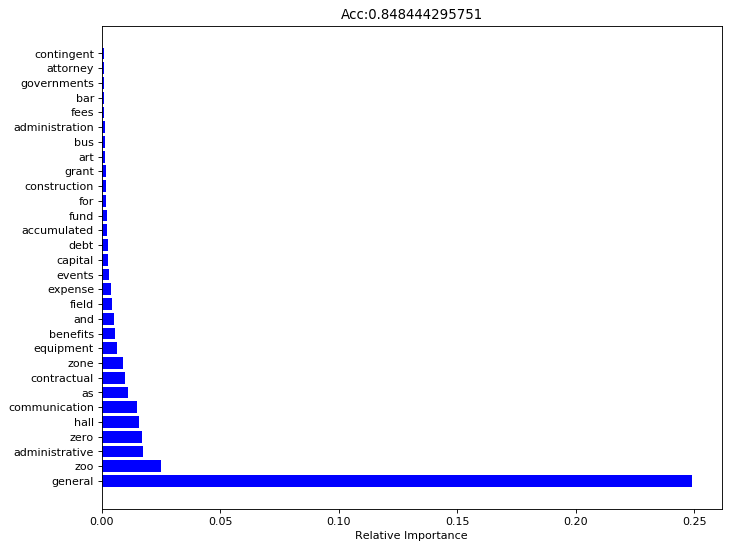

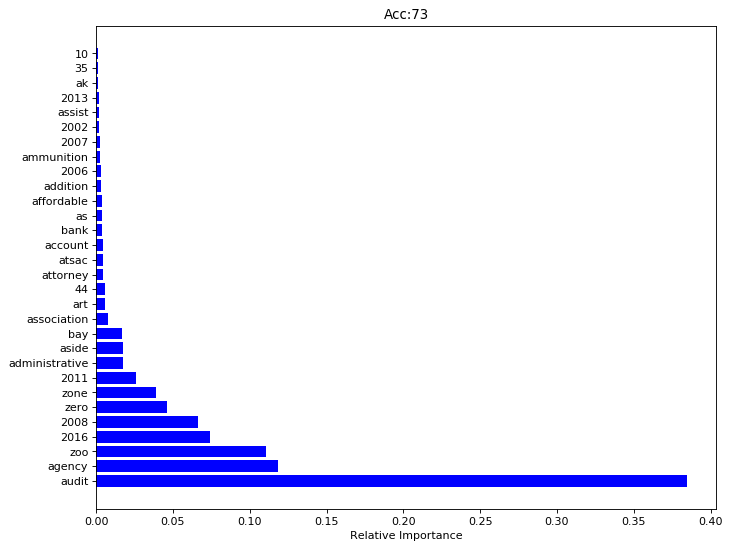

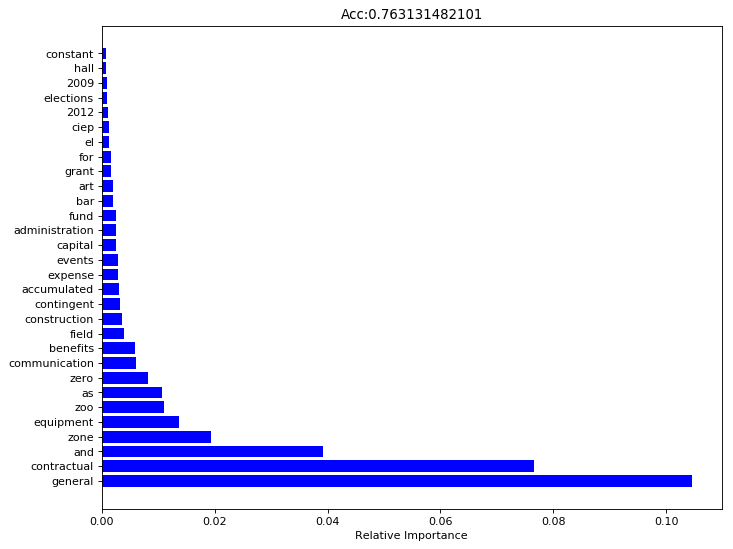

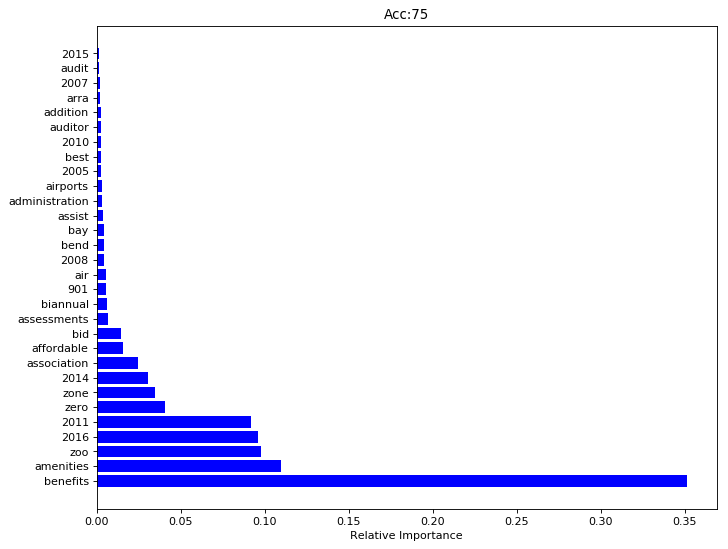

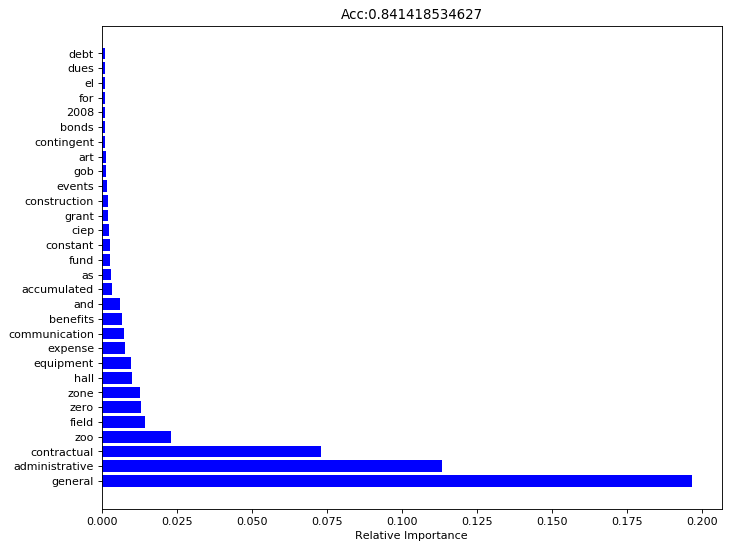

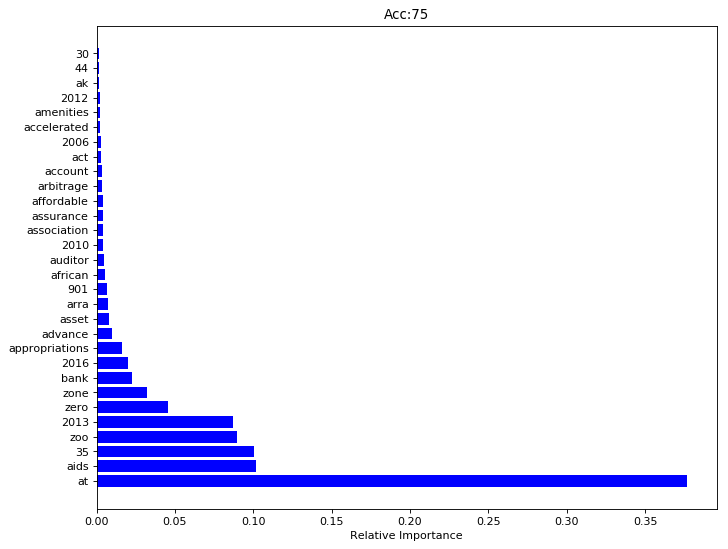

In [34]:
from random import random

max_accuracy = 0

for i in range(3):
    
    state = int(random()*100) 
    
    # get results of full data
    rfc = RandomForestClassifier(n_estimators=5, random_state=state, max_features='log2')
    rfc.fit(X_train, Y_train)
    acc = rfc.score(X_test, Y_test)
    print("Random State ", state, "Full Data Accuracy: ", acc)
    plot_ngram_rfc(rfc, 2*i, acc)
    
    X_imp_train, Y_imp_train, X_imp_test, Y_imp_test = get_reduced_features(rfc)
    
    # get results of only important data
    rfc = RandomForestClassifier(n_estimators=5, random_state=state, max_features='log2')
    rfc.fit(X_imp_train, Y_imp_train)
    acc = rfc.score(X_imp_test, Y_imp_test)
    print("Random State ", state, "Important Data Accuracy: ", acc)
    plot_ngram_rfc(rfc, 2*i+1, int(100*acc))

# Boosted Decision Tree

Because of the inconsistencies with the decision tree, I think there is too high of a potential to have a bad split to confidently use a decision tree on the data and be confident about the accuracy. I think the reason for this is that there are so many different categories, a large number of which do not matter too much. In order to combat this, I'm going to try instead a boosted tree, which will run through every node and simply correct its previous attempts

In [35]:
from sklearn.ensemble import AdaBoostClassifier

gbt = AdaBoostClassifier(n_estimators=50, learning_rate=.5)

gbt.fit(X_imp_train, Y_imp_train)

gbt.score(X_imp_test, Y_imp_test)

0.70224155235864838

So this actually scored consistently far worse than the random forest- I honestly was not sure how much the gradient boosting would help vs random sampling

# Naive Bayes

I've been focused a lot on improving the information passed into some variation of decision tree. This is because of the ratio of features to the size of the training data. However, in this ngram encoding of the account name, I feel there may be some potential for bayesian statistics. Might as well try :)

In [36]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

First gonna just run gaussian bc no hyper parameter tinkering but not expecting great results due to nature of data

In [37]:
gb = GaussianNB()
gb.fit(X_ngram_train, Y_ngram_train)
print("Guassian", gb.score(X_ngram_test, Y_ngram_test))

Guassian 0.182335229174


Yep

So now I'm just gonna run Multi and Bernouli classifiers with a series of alpha values and see how they do

In [38]:
for i in range(7):
    
    print("Alpha: ", i)
    print("")

    mb = MultinomialNB(alpha=i)
    mb.fit(X_ngram_train, Y_ngram_train)
    print("Multi", mb.score(X_ngram_test, Y_ngram_test))

    bb = BernoulliNB(alpha=i)
    bb.fit(X_ngram_train, Y_ngram_train)
    print("Bernouli", bb.score(X_ngram_test, Y_ngram_test))
    
    print("\n")

Alpha:  0

Multi 0.187019069923


/home/kian/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Bernouli 0.202074272332


Alpha:  1

Multi 0.559718969555
Bernouli 0.811642689863


Alpha:  2

Multi 0.571094011375
Bernouli 0.853462696554


Alpha:  3

Multi 0.614586818334
Bernouli 0.881565741051


Alpha:  4

Multi 0.624958179993
Bernouli 0.879223820676


Alpha:  5

Multi 0.622950819672
Bernouli 0.880896620943


Alpha:  6

Multi 0.643693542991
Bernouli 0.83606557377




# Very Nice Results

Especially the bernouli classifier. The accuracy is a little lower than the best case of random forest but I greatly prefer Bayesian methods because, even though they are viewed as pseudo-statistics, they are still very interpretable, whereas ensemble methods such as random forest approach the blackbox types of ML

# This Time I think We Got Real Features

I think the inconsistency of the random forest, coupled with the ussually high accuracy of RFC makes me think 2 things:

1. This is a real features set that gives solid predicition based on the vector distribution
2. The features are too complex to consistently hit with the RFC

## Build Training Set

In [39]:
X_train, Y_train, X_test, Y_test = account_cv_split(X, full_data["Expense_Type"], index)


label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
label_encoder.fit(Y_test)

Y_train = label_encoder.transform(Y_train).reshape([Y_train.shape[0], 1])
Y_test = label_encoder.transform(Y_test).reshape([Y_test.shape[0], 1])
    
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(Y_train, Y_test)

Y_train = onehot_encoder.transform(Y_train)
Y_test = onehot_encoder.transform(Y_test)

# Set Up Basic Model

# Time to Make Final Predictions

Recreate Training set and make n_grams for the entire training set. Then make the same n_grams for the entire test set using the vectorizer

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

# Use full training data for model
account_names = full_data["Account_Name"].tolist()
new_account_names = single_empty["Account_Name"].tolist()

# fit n-grams to training set
make_ngram = CountVectorizer()
make_ngram.fit(account_names)

# make training set
n_grams = make_ngram.transform(account_names).toarray()
other_data = full_data[guaranteed].as_matrix()
X = np.concatenate([other_data, n_grams], axis=1)
Y = full_data["Expense_Type"]

# Create X_unknown
new_n_grams = make_ngram.transform(new_account_names).toarray()
guaranteed_columns = single_empty[guaranteed].as_matrix()

### Train a bernoulli classifier when the account name is provided CV 88% ACC

In [64]:
final_classifier = BernoulliNB(alpha=4)

X_train_final = np.concatenate([X_ngram_test, X_ngram_train], axis=0)
Y_train_final = np.concatenate([Y_ngram_test, Y_ngram_train], axis=0)

final_classifier.fit(X_train_final, Y_train_final)

account_pred = final_classifier.predict(new_n_grams)

### Train the RFC Model on the subset that has no account description -- CV 75% acc

In [65]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(full_data[guaranteed], full_data["Expense_Type"])

g_pred = rfc.predict(all_empty[guaranteed])

In [66]:
expenses = df["Expense_Type"]

nulls = expenses.isnull()

no_accounts = df["Account_Name"].isnull()

expenses = expenses.as_matrix()

num_no_account = 0
num_account = 0


for i, na in enumerate(nulls):
    if (na):
        
        if no_accounts[i]:
            expenses[i] = g_pred[num_no_account]
            num_no_account +=1
            
        else:
            expenses[num_account] = account_pred[num_account]
            num_account+=1
            
df["Expense_Type"] = pd.Series(expenses)

In [67]:
df.to_excel("final_filled_budget.xlsx")

# Now Change DF to New one to FILL

There was some discrepency between the new budget data and old, so I'm gonna predict on the new trained on the old and send them both over

In [84]:
df = pd.read_csv("data/total_data.csv")

In [85]:
decoders = {}


decoders["Department_Name"] = encode_column(df, "Department_Name")
decoders["SubDepartment_Name"] = encode_column(df, "SubDepartment_Name")

full_data = df[df["Expense_Type"].notnull()]
full_data = full_data.dropna(how='any')

encode_column(full_data, "Expense_Type")
encode_column(full_data, "Program_Priority")
encode_column(full_data, "Program_Name")
encode_column(full_data, "Account_Name")


empty_data = df[False == df["Expense_Type"].notnull()]


single_empty = empty_data[empty_data["Account_Name"].notnull()]
all_empty = empty_data[False == empty_data["Account_Name"].notnull()]

priorities = full_data["Program_Priority"].unique()
programs = full_data["Program_Name"].unique()
expenses = full_data["Expense_Type"].unique()
departments = full_data["Dept_Code"].unique()

guaranteed = ["Encoded_SubDepartment_Name", "Encoded_Department_Name", "Appropriation"]
not_guaranteed = ["Encoded_Program_Name", "Encoded_Program_Priority", "Encoded_Account_Name"]

all_keys = guaranteed + not_guaranteed

In [86]:
all_empty.shape

(204, 16)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

# Use full training data for model
account_names = full_data["Account_Name"].tolist()
new_account_names = single_empty["Account_Name"].tolist()

# fit n-grams to training set


# make training set
n_grams = make_ngram.transform(account_names).toarray()
other_data = full_data[guaranteed].as_matrix()
X = np.concatenate([other_data, n_grams], axis=1)
Y = full_data["Expense_Type"]

# Create X_unknown
new_n_grams = make_ngram.transform(new_account_names).toarray()
guaranteed_columns = single_empty[guaranteed].as_matrix()

In [88]:
account_pred = final_classifier.predict(new_n_grams)
g_pred = rfc.predict(all_empty[guaranteed])

In [89]:
df = pd.read_csv("data/total_data.csv")

expenses = df["Expense_Type"]

nulls = expenses.isnull()

no_accounts = df["Account_Name"].isnull()

expenses = expenses.as_matrix()

num_no_account = 0
num_account = 0


for i, na in enumerate(nulls):
    if (na):
        
        if no_accounts[i]:
            expenses[i] = g_pred[num_no_account]
            num_no_account +=1
            
        else:
            expenses[num_account] = account_pred[num_account]
            num_account+=1
            
df["Expense_Type"] = pd.Series(expenses)

In [90]:
df.to_excel("NewPred_OldData.xlsx")